<a href="https://colab.research.google.com/github/jcmachicao/deep_learning_2025_curso/blob/main/S07__XAI_Captum_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPLICABILIDAD CON CAPTUM (MNIST)
-----------------------------------

In [ ]:
!pip install torch torchvision captum matplotlib

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients, Saliency
from captum.attr import visualization as viz

In [2]:
# 1️⃣ Datos
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 524kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.25MB/s]


In [3]:
# 2️⃣ Modelo simple
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Entrenamiento rápido (solo para demo)
for epoch in range(1):
    for images, labels in torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [11]:
# 3️⃣ Tomamos una muestra del test set
images, labels = next(iter(testloader))
image = images[10].unsqueeze(0)
label = labels[10].item()

# 4️⃣ Predicción del modelo
output = model(image)
pred_label = output.argmax(dim=1).item()

print(f"Etiqueta real: {label} | Predicha: {pred_label}")

Etiqueta real: 6 | Predicha: 6


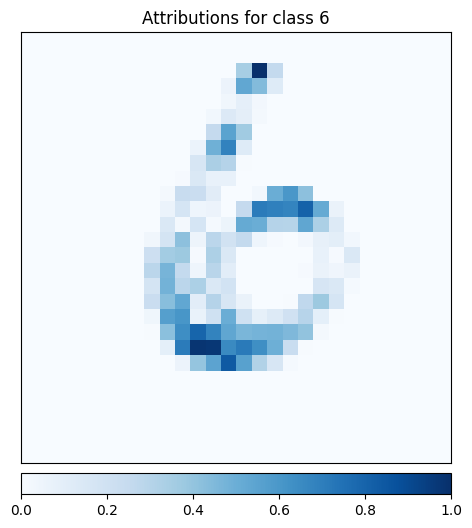

(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': 'Attributions for class 6'}>)

In [12]:
# 5️⃣ Aplicar Integrated Gradients
ig = IntegratedGradients(model)
attr, delta = ig.attribute(image, target=pred_label, baselines=image*0, return_convergence_delta=True)

# 6️⃣ Visualización
attr = attr.squeeze().detach().numpy()
orig = image.squeeze().numpy()

# Add a channel dimension to the grayscale images for visualization
attr = attr[..., np.newaxis]
orig = orig[..., np.newaxis]

viz.visualize_image_attr(attr, orig,
    method="heat_map",
    sign="absolute_value",
    show_colorbar=True,
    title=f"Attributions for class {pred_label}")

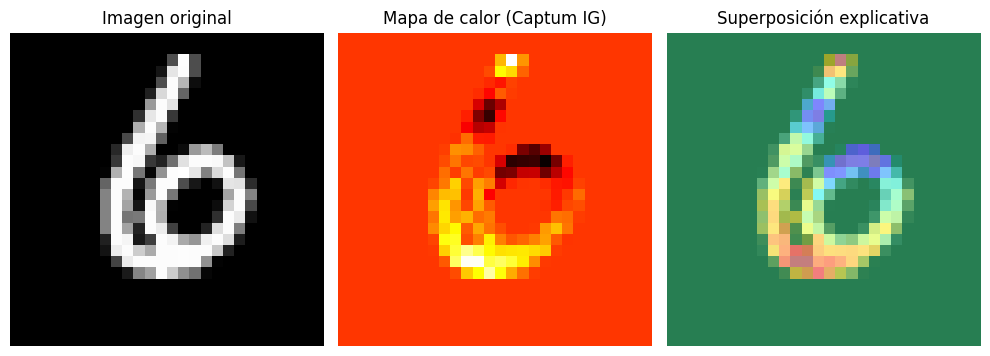

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import visualization as viz

# Normalizar el mapa de atribuciones para visualización
attr_norm = (attr - attr.min()) / (attr.max() - attr.min())

# Configurar figuras
fig, ax = plt.subplots(1, 3, figsize=(10,4))

# 1️⃣ Imagen original
ax[0].imshow(orig, cmap='gray')
ax[0].set_title("Imagen original")
ax[0].axis('off')

# 2️⃣ Mapa de calor de atribuciones
ax[1].imshow(attr_norm, cmap='hot')
ax[1].set_title("Mapa de calor (Captum IG)")
ax[1].axis('off')

# 3️⃣ Superposición (overlay)
ax[2].imshow(orig, cmap='gray')
ax[2].imshow(attr_norm, cmap='jet', alpha=0.5)
ax[2].set_title("Superposición explicativa")
ax[2].axis('off')

plt.tight_layout()
plt.show()